In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.rcParams['pdf.fonttype'] = 42

In [2]:
from src.DMS_Profile import Genome, Annotation, Targeted_DMS_Profile, targeted_combine_profiles, DMS_Profile, combine_profiles, gini_for_transcripts, bulk_2_target
import pickle

In [3]:
genome = Genome('../data/genome/scer_chr_kan.FASTA')
annotation = Annotation('../data/genome/scer_kan.gff')

intron-containing transcripts: 283
intron-less transcripts: 6290
structured RNA transcripts: 100


In [4]:
# load CoSTseq data as dummy replicates (not actually used for anything)

dms_pro_1 = combine_profiles([ DMS_Profile('../data/processed/pro_wild_1_mRNA_agg.pkl', 'wild_R1', genome), 
                               DMS_Profile('../data/processed/pro_wild_2_mRNA_agg.pkl', 'wild_R2', genome), 
                               DMS_Profile('../data/processed/pro_wild_3_mRNA_agg.pkl', 'wild_R3', genome),
                               DMS_Profile('../data/processed/pro_wild_4_mRNA_agg.pkl', 'wild_R4', genome), 
                               DMS_Profile('../data/processed/pro_wild_5_mRNA_agg.pkl', 'wild_R5', genome), 
                               DMS_Profile('../data/processed/pro_wild_6_mRNA_agg.pkl', 'wild_R6', genome),
                               DMS_Profile('../data/processed/pro_wild_7_mRNA_agg.pkl', 'wild_R7', genome), 
                               DMS_Profile('../data/processed/pro_wild_8_mRNA_agg.pkl', 'wild_R8', genome)], 'all_pro', genome, min_cov=1000)


dms_pro_2 = combine_profiles([ DMS_Profile('../data/processed/pro_dbp7_1_mRNA_agg.pkl', 'dbp7_R1', genome), 
                               DMS_Profile('../data/processed/pro_dbp7_2_mRNA_agg.pkl', 'dbp7_R2', genome), 
                               DMS_Profile('../data/processed/pro_dbp7_3_mRNA_agg.pkl', 'dbp7_R3', genome),
                               DMS_Profile('../data/processed/pro_dbp3_1_mRNA_agg.pkl', 'dbp3_R1', genome), 
                               DMS_Profile('../data/processed/pro_dbp3_2_mRNA_agg.pkl', 'dbp3_R2', genome), 
                               DMS_Profile('../data/processed/pro_dbp3_3_mRNA_agg.pkl', 'dbp3_R3', genome)], 'all_pro', genome, min_cov=1000)
                   
dms_pro_3 = combine_profiles([ DMS_Profile('../data/processed/pro_spt4_1_mRNA_agg.pkl', 'spt4_R1', genome), 
                               DMS_Profile('../data/processed/pro_spt4_2_mRNA_agg.pkl', 'spt4_R2', genome), 
                               DMS_Profile('../data/processed/pro_spt4_3_mRNA_agg.pkl', 'spt4_R3', genome),
                               DMS_Profile('../data/processed/pro_stm1_1_mRNA_agg.pkl', 'stm1_R1', genome), 
                               DMS_Profile('../data/processed/pro_stm1_2_mRNA_agg.pkl', 'stm1_R2', genome), 
                               DMS_Profile('../data/processed/pro_stm1_3_mRNA_agg.pkl', 'stm1_R3', genome)], 'all_pro', genome, min_cov=1000)

/opt/homebrew/Caskroom/miniforge/base/envs/CoST/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [5]:
from src.DMS_Profile import bulk_2_target, targeted_combine_profiles
from src.dms_utils import rsample, get_coords, plot_structure, fold, gini

In [6]:
# extract U2 snRNA data for targeted analysis

chrom = 1
coords = (680687, 681862)
avg_win = 6

genome_lsr1 = Genome('../data/genome/scer_chr_kan.FASTA', coords=(chrom, coords[0], coords[1]), reverse=True)

lsr1_1 = bulk_2_target(dms_pro_1, chrom, '-', coords, genome_lsr1)
lsr1_2 = bulk_2_target(dms_pro_2, chrom, '-', coords, genome_lsr1)
lsr1_3 = bulk_2_target(dms_pro_3, chrom, '-', coords, genome_lsr1)
lsr1 = targeted_combine_profiles([lsr1_1, lsr1_2, lsr1_3], 'lsr1', genome_lsr1, min_cov=2000, cov_corr_individual=True, use_G=False, use_U=True, per_exclude=5)

In [7]:
def gini_windows(rea, mask, w, min_n=20):
    ginis = []
    mreas = []
    x = []
    for window in range(len(rea)-w):
        if len((rea[window:window+w])[mask[window:window+w]]) >= min_n:
            gini_w = gini((rea[window:window+w])[mask[window:window+w]])
            avg_re = np.median((rea[window:window+w])[mask[window:window+w]])
            ginis.append(gini_w)
            mreas.append(avg_re)
        else:
            ginis.append(np.nan)
            mreas.append(np.nan)
        x.append((window+window+w)/2)
    return(x, ginis, mreas)

# base pair distance for every paired nt
# separate into opened and closed
def get_partner(dbr):
    bpdict = {}
    opened = []
    for i, d in enumerate(dbr):
        if d == '(':
            opened.append(i)
        elif d == ')':
            partner = opened.pop(-1)
            if i not in bpdict:
                bpdict[i] = partner
                bpdict[partner] = i
    
    if opened:
        print('parentheses unmatched!')
        return(None)
    else:
        return(bpdict)

In [8]:
# set secondary structure models for known regions, predict based on DMS reactivity for the rest

# known structures of 3' and 5' region
stt1 = '.......(((..(((....)))..)))....................(((((((......)))))))((((((.....))).)))...............................................................'
stt2 = '.......(((..(((....)))..)))..........................((((((((.(((((((((((.....))).))).....)))))..))))))))...........................................'
end1 = '.....(((((((.(((....(((((((..........)).)))))))))))))))............................................'

# predict structure with 2nd half dms reactivities
half_mask = np.array(442*[False] + (len(genome_lsr1.seq[148:])-442)*[True])

In [9]:
# prediction takes a long time, prediction is provided
run_prediction = False
if run_prediction:
    p, dG, dbr = rsample(genome_lsr1.seq[148:], lsr1.rat[148:]*lsr1.vec_norm[148:], half_mask & ~genome_lsr1.mask_G()[148:], rnastructure_path='/Users/leo/Builds/RNAstructure/exe')
else:
    dbr = '.((((((..(((((.(.((((..((......(((((((((.....(((..(((((((....(((((((.....((((((((((.((((((((((((((((((((....(((((((((((.(((((((((((.(((....((((((.((((((.((((.(((((((((((((((((((((((((((((..(((((.....(((.((((((..(((.....))).....(((((((((.......((((((((((((((((...((((((...(((((((((((.((((((((((((...(((((...((((((((((((((.((....(((((((.(((((((((((((((((((((((((((((((((.((((.((((((((..(((((((..((((.((((((.((((((((((.((..((((((((...((((.(((((.(((((((((((((.(((....))).))))))))..)))))..(((((((....))))))).))))).))))..))))))))..)).)))))))))).)))))).))))...)))))))....))))))))..)))).))))))))))))))))))).....)))))))))))))).)))))))..)).))))))))))))))..)))))..)))))))))))))))))).)))))..)))))).))))))))))...)))))).....)))))))))..((((((....)))))).)))))).)))....)))))..)))))))))))..)))))))))))...))))))).)))).)))))).))))))))).))))))))))))))))))))))...))))......))))))))))))))))...)))))))))))))))))....)))))))..)))....)))))))))))..))))).)))))..))))))(((((((((((((((.........(((((((((....)))))).)))...))))))..))))))))).....................'

In [10]:
bpdict = get_partner(dbr)
# add 0 for no pairs
for i in range(len(dbr)):
    if i not in bpdict:
        bpdict[i] = i

bp_dist = [abs(nt-bpdict[nt]) for nt in bpdict]
x_plot_bp = np.array(list(bpdict.keys()))
order_bp = x_plot_bp.argsort()
x_plot_bp = np.array(sorted(x_plot_bp))
bp_dist = np.array([bp_dist[i] for i in order_bp])

# gini index
w = 70
mask_acu = genome_lsr1.mask_A()|genome_lsr1.mask_C()|genome_lsr1.mask_U()
x_gini_nas, gini_nas, mrea_nas = gini_windows(lsr1.rat*lsr1.vec_norm, mask_acu&lsr1.mask, w, min_n=20)

# Figure 2a

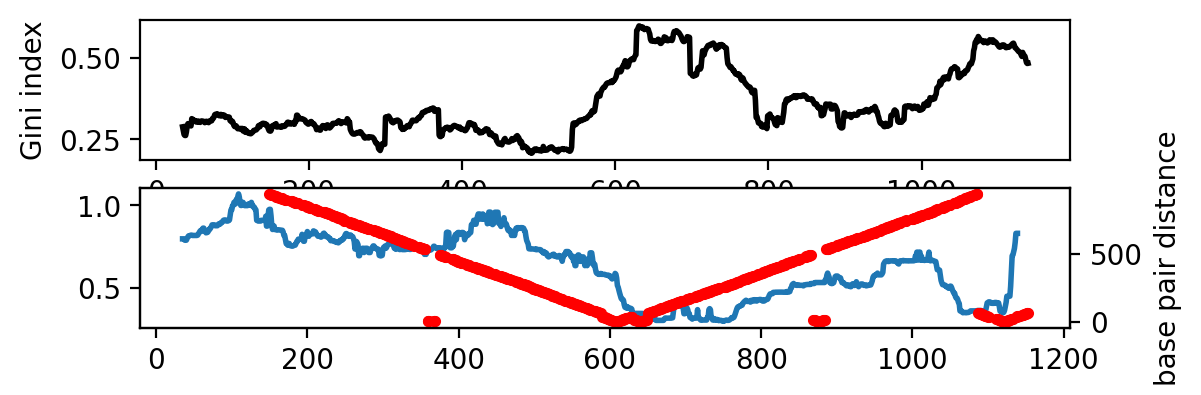

In [11]:
fig, axs = plt.subplots(2, 1, figsize=[6, 2])

axs[0].plot(x_gini_nas, gini_nas, lw=2, color='k')
ax1 = axs[1].twinx()

ax1.plot(148+x_plot_bp[bp_dist>0], bp_dist[bp_dist>0], '.', color='r')
axs[0].set_ylabel('Gini index')
ax1.set_ylabel('base pair distance')

axs[1].plot(x_gini_nas, mrea_nas, lw=2)
plt.show()

# Figure 2b

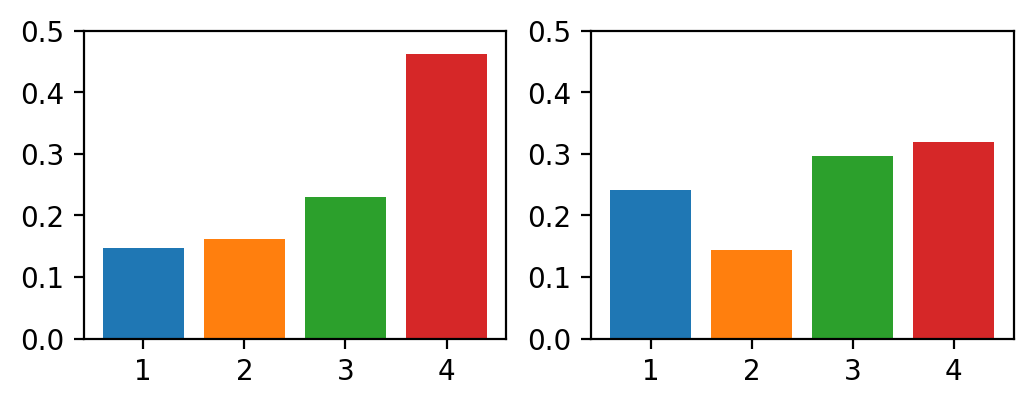

In [12]:
fig, axs = plt.subplots(1, 2, figsize=[6,2])

axs[0].bar(1, genome_lsr1.seq[150:590].count('A')/len(genome_lsr1.seq[150:590]))
axs[0].bar(2, genome_lsr1.seq[150:590].count('C')/len(genome_lsr1.seq[150:590]))
axs[0].bar(3, genome_lsr1.seq[150:590].count('G')/len(genome_lsr1.seq[150:590]))
axs[0].bar(4, genome_lsr1.seq[150:590].count('T')/len(genome_lsr1.seq[150:590]))

axs[1].bar(1, genome_lsr1.seq[651:1077].count('A')/len(genome_lsr1.seq[651:1077]))
axs[1].bar(2, genome_lsr1.seq[651:1077].count('C')/len(genome_lsr1.seq[651:1077]))
axs[1].bar(3, genome_lsr1.seq[651:1077].count('G')/len(genome_lsr1.seq[651:1077]))
axs[1].bar(4, genome_lsr1.seq[651:1077].count('T')/len(genome_lsr1.seq[651:1077]))
plt.setp(axs, ylim=[0, 0.5])
plt.show()

# Figure 2c

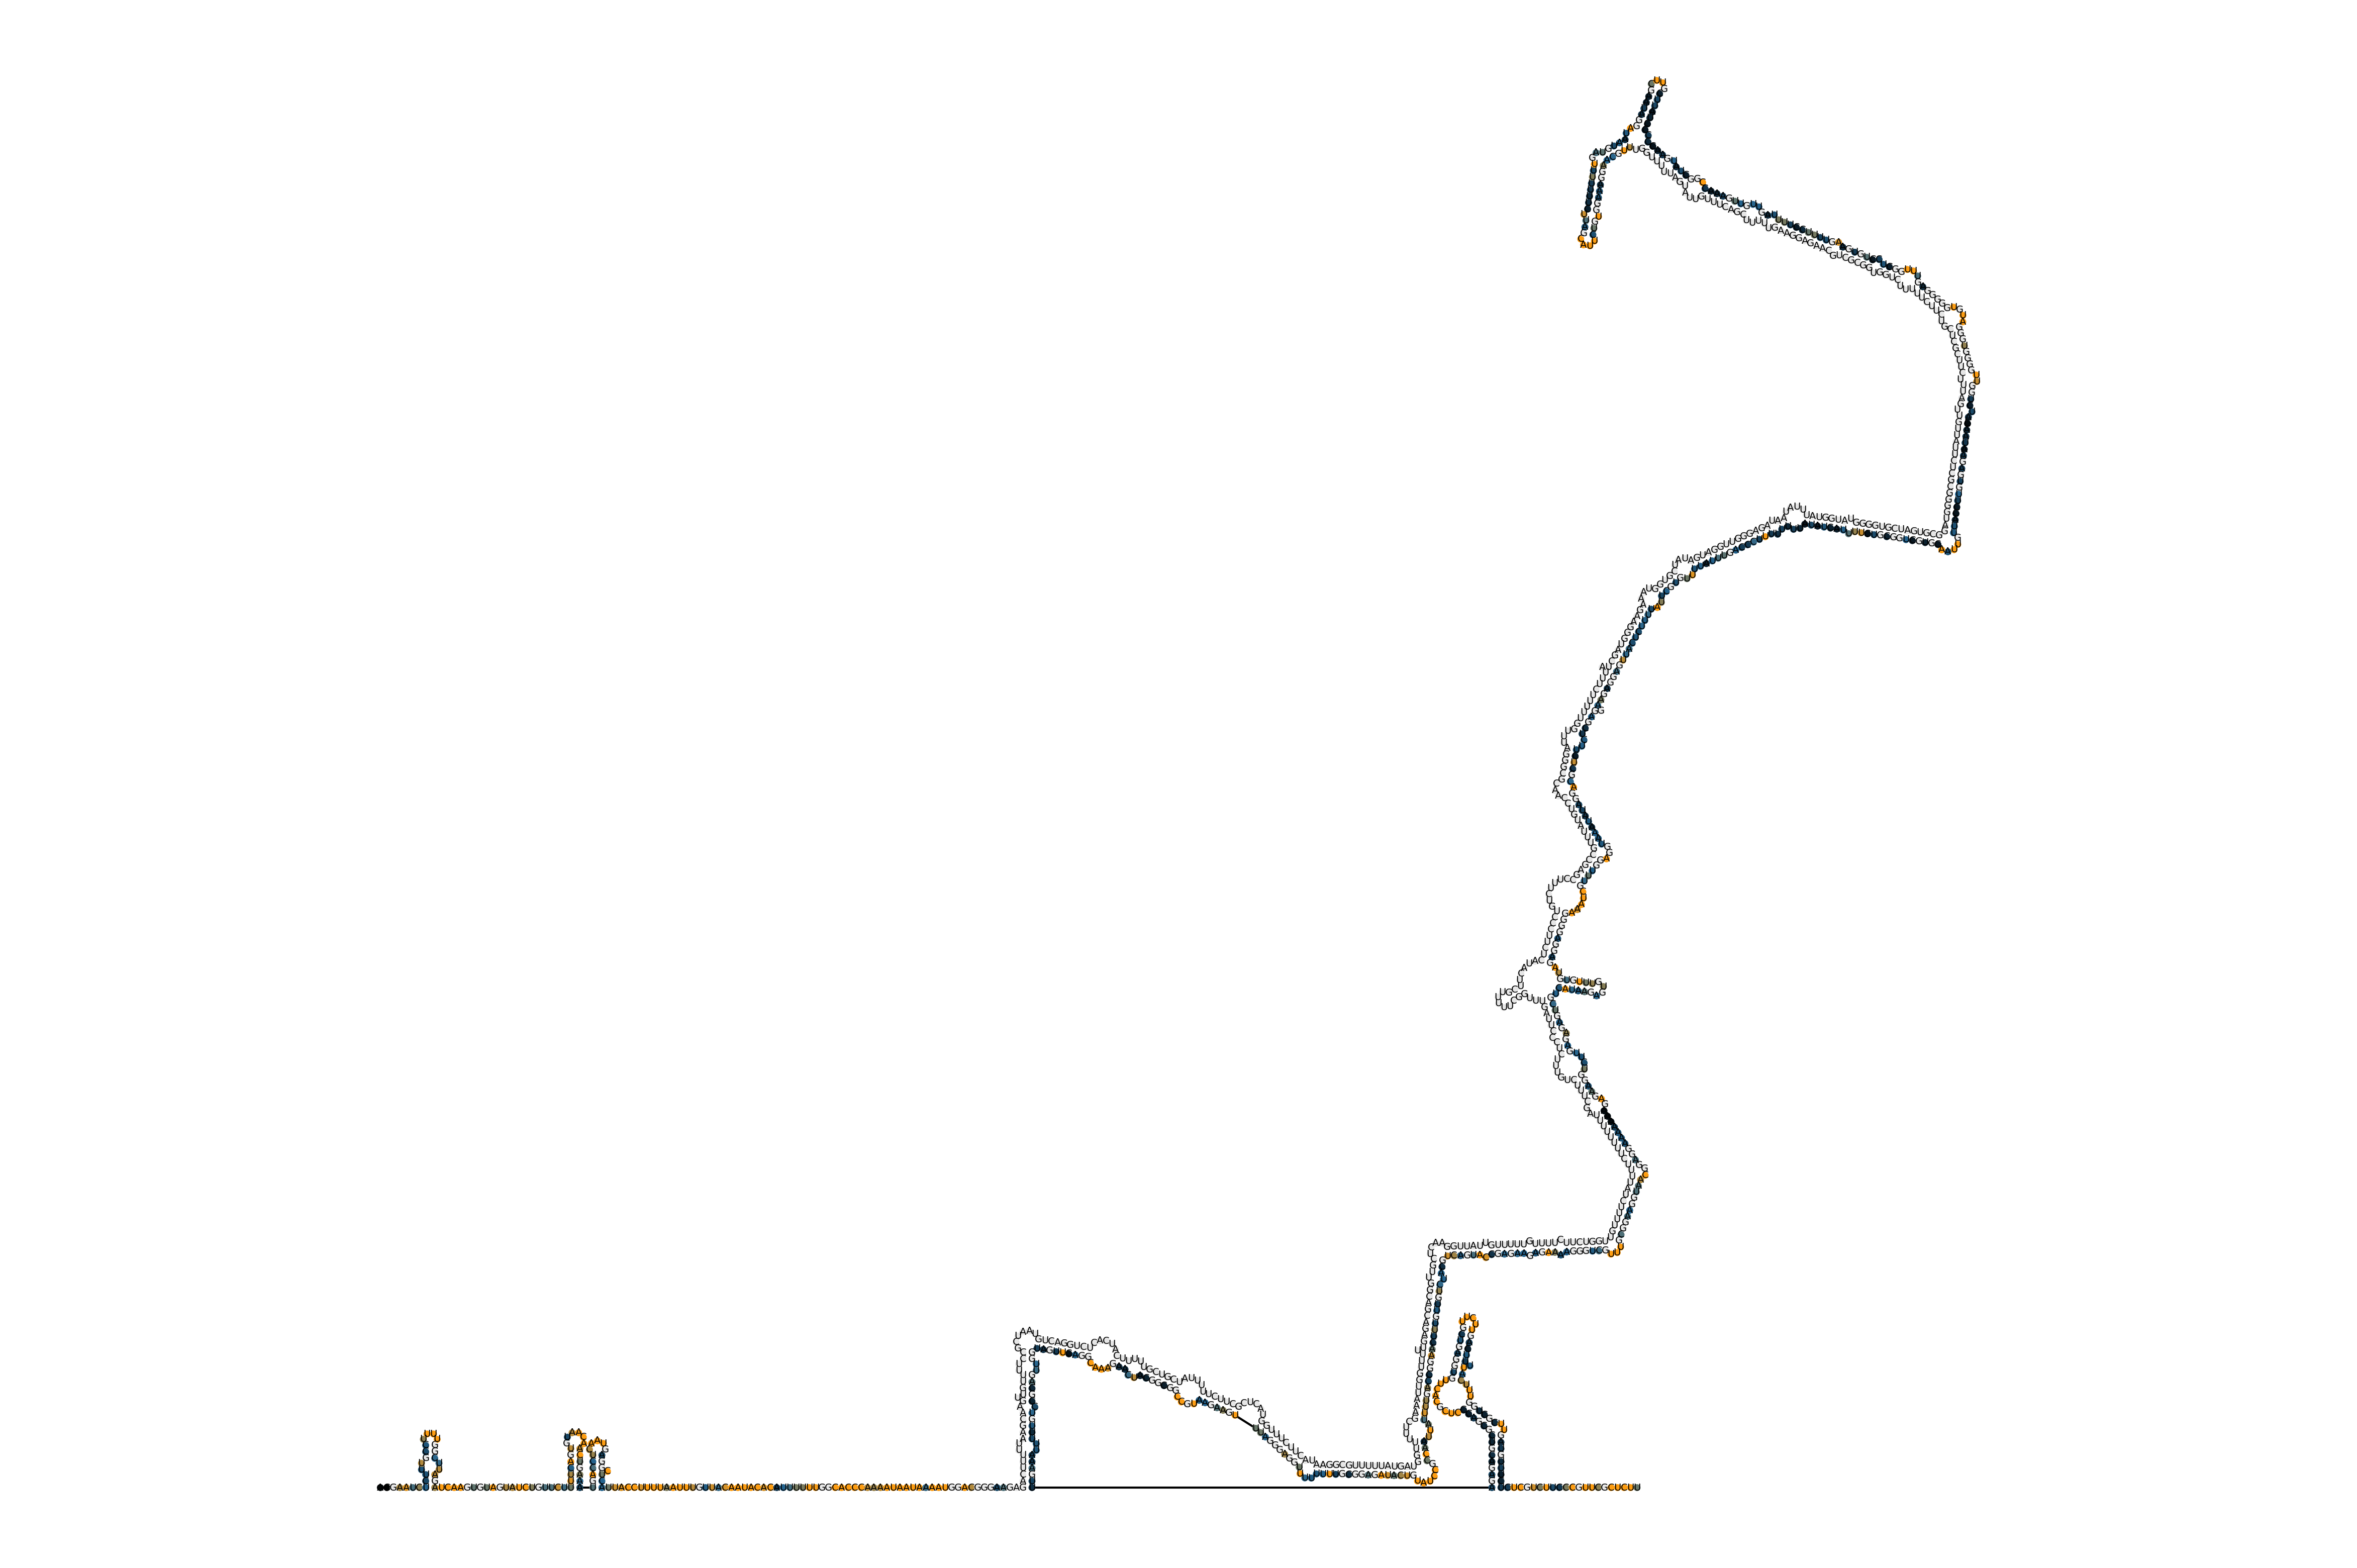

In [13]:
coords = get_coords(genome_lsr1.seq, stt1 + dbr)
plot_structure(coords, genome_lsr1.seq, lsr1.rat*lsr1.vec_norm, ~genome_lsr1.mask_G() & np.hstack([[True]*148, half_mask]), figsize=(30, 20), vmin=0, vmax=1, circle_size=25, cmap_loc = '../cmap.txt')
plt.show()

# Figure S2a

In [14]:
# extract SCR1 data for targeted analysis

chrom = 4 
coords = (441986, 442508) 

genome_scr1 = Genome('../data/genome/scer_chr_kan.FASTA', coords=(chrom, coords[0], coords[1]), reverse=False)

scr1_1 = bulk_2_target(dms_pro_1, chrom, '+', coords, genome_scr1)
scr1_2 = bulk_2_target(dms_pro_2, chrom, '+', coords, genome_scr1)
scr1_3 = bulk_2_target(dms_pro_3, chrom, '+', coords, genome_scr1)
scr1 = targeted_combine_profiles([scr1_1, scr1_2, scr1_3], 'scr1', genome_scr1, min_cov=1000, cov_corr_individual=True, use_G=False, use_U=True, per_exclude=5)

/opt/homebrew/Caskroom/miniforge/base/envs/CoST/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


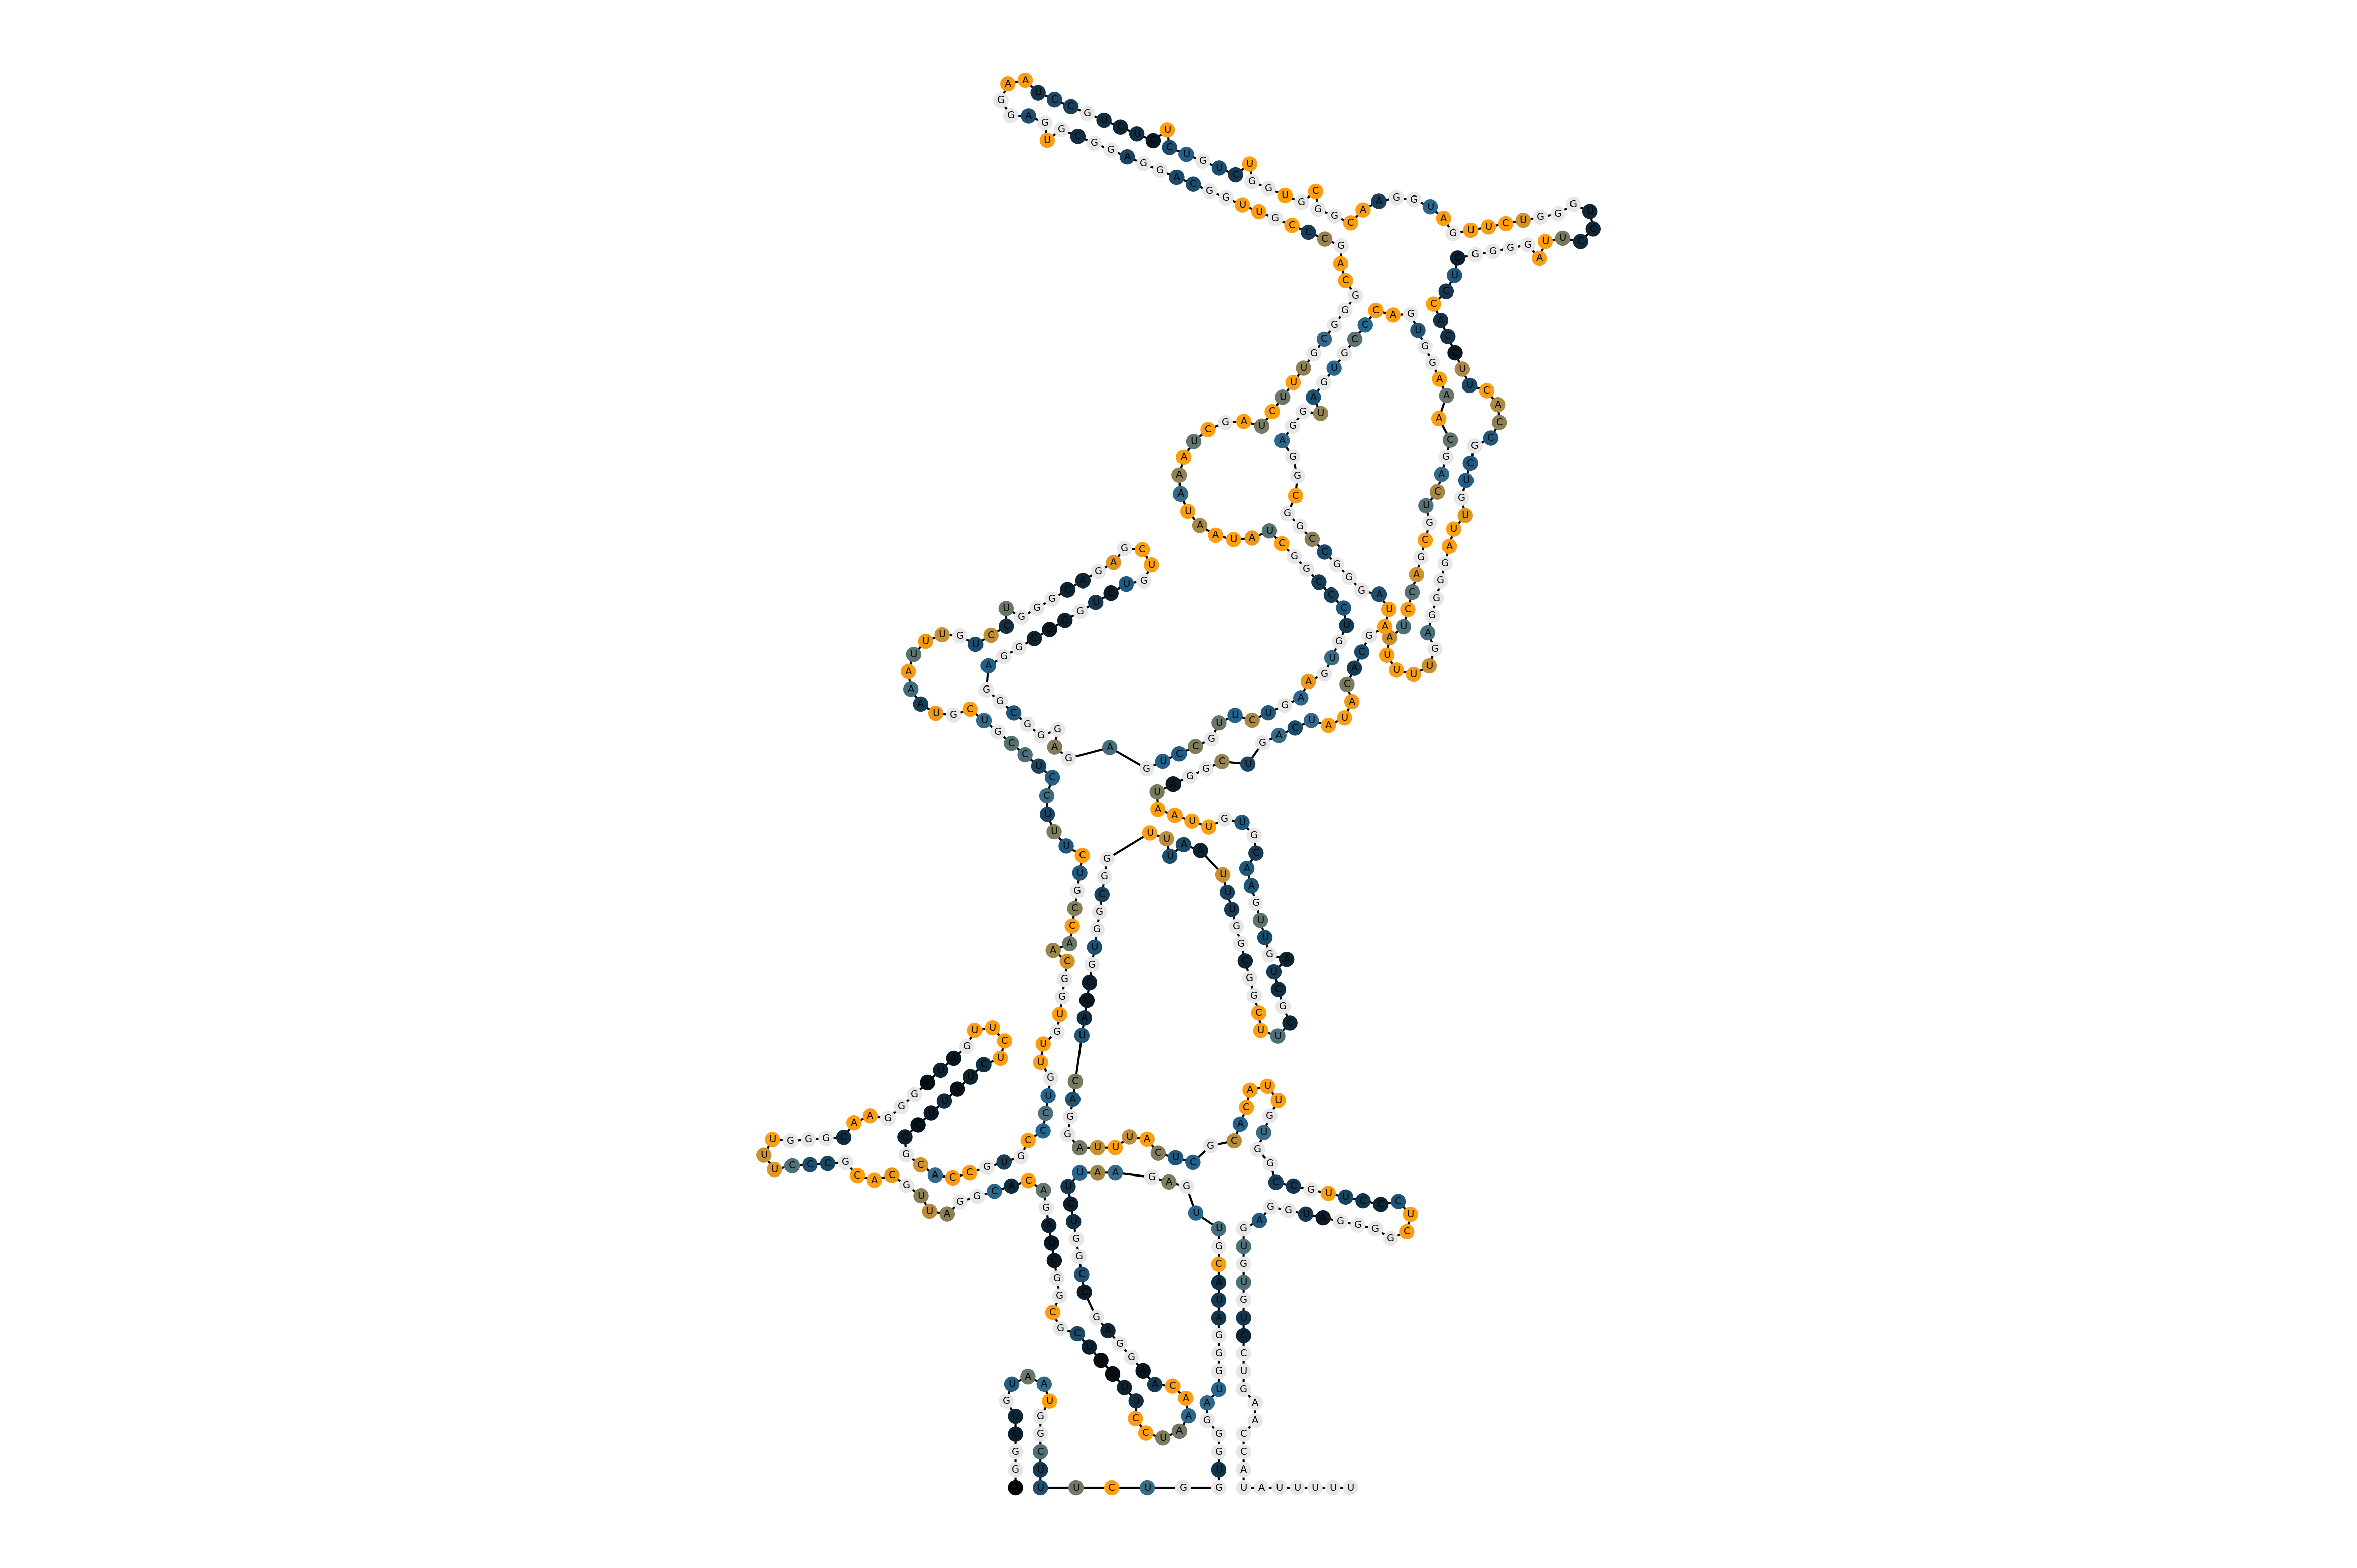

In [15]:
# plot on known SCR1 structure
dbr_scr1 = '(((((.....)))))....((((..((((((((((.(((((((((((((((((((.......))))))..)))))))(((((..(((..((((...))))..(((((((....))))))))))))))).((((..(((((.((((((....(((((((.........(((.(((((((....))))))))))))))).)).(((((..((((.(((((((((((............((((((((((..((((((((((((((((((.((....)))))))).))))).)))).)))......(((((((....)).)))))..((((((....((((.(((((((......))))))).)))).)))))).))))))).)))...)))))))...))))...)))).)))))((((....((((((.(((...))))))))))).))))))))))))))))))))..))).(((...))).(((((((....))))))).))))))))))..))))......'

coords = get_coords(genome_scr1.seq, dbr_scr1)
plot_structure(coords, genome_scr1.seq, scr1.rat*scr1.vec_norm, ~genome_scr1.mask_G() & scr1.mask, figsize=(30, 20), vmin=0, vmax=1, circle_size=120, cmap_loc='../cmap.txt')

plt.show()

# Figure S2b

In [16]:
bpdict = get_partner(dbr_scr1)
# add 0 for no pairs
for i in range(len(dbr_scr1)):
    if i not in bpdict:
        bpdict[i] = i

bp_dist = [abs(nt-bpdict[nt]) for nt in bpdict]
x_plot_bp = np.array(list(bpdict.keys()))
order_bp = x_plot_bp.argsort()
x_plot_bp = np.array(sorted(x_plot_bp))
bp_dist = np.array([bp_dist[i] for i in order_bp])

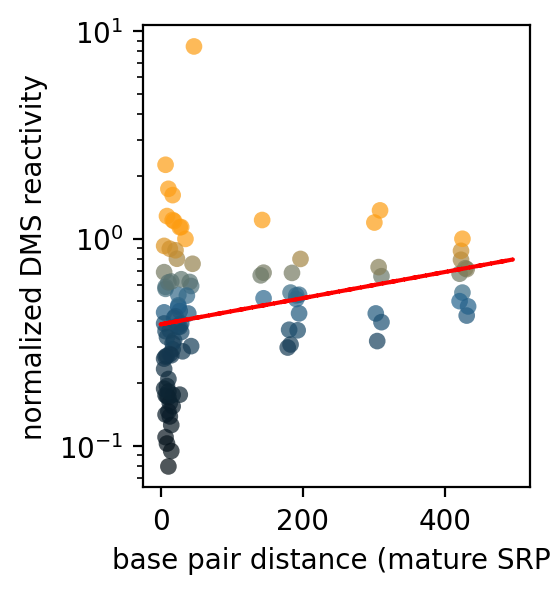

In [17]:
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as mplc

# get colors
cmap = np.array(pd.read_csv('../cmap.txt', header=None))/255
cmap = mplc.ListedColormap(cmap)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
m = cm.ScalarMappable(norm=norm, cmap=cmap)
clrs = m.to_rgba(scr1.rat*scr1.vec_norm)

# linear fit in log space
a, b = np.polyfit(bp_dist[~genome_scr1.mask_G() & scr1.mask & bp_dist>0], 
                  np.log10((scr1.rat*scr1.vec_norm)[~genome_scr1.mask_G() & scr1.mask & bp_dist>0]),
                  1)

plt.figure(figsize=[2.5,3])
plt.scatter(bp_dist[~genome_scr1.mask_G() & scr1.mask & bp_dist>0], (scr1.rat*scr1.vec_norm)[~genome_scr1.mask_G() & scr1.mask & bp_dist>0], color=clrs[~genome_scr1.mask_G() & scr1.mask & bp_dist>0], edgecolors='none', alpha=0.7)
plt.plot(bp_dist, 10**(a*bp_dist+b), '--r')
plt.yscale('log')
plt.xlabel('base pair distance (mature SRP)')
plt.ylabel('normalized DMS reactivity')
plt.show()